In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
# Data
orders_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/orders_dataset.csv')
customer_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/customers_dataset.csv')
order_reviews_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/order_reviews_dataset.csv')
order_items_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/order_items_dataset.csv')
order_payments_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/order_payments_dataset.csv')
geolocation_df = pd.read_csv('E:/Data Kerja Fito/Test Perqara/20220721_D&I_Assesment Data/data/geolocation_dataset.csv')

# Segmentasi dan Klasifikasi Perilaku Pembelian

## Eksplorasi Data

In [3]:
# Cek missing value
def cek_missing_values(data):
    if data.isnull().values.any() == False:
        print('Data tidak mengandung missing value')
    else:
        for column in data.columns:
            if data[column].isnull().values.any():
                print(f"Kolom '{column}' mengandung nilai null.")

In [4]:
# Cek missing values pada data orders_df
cek_missing_values(orders_df)

Kolom 'order_approved_at' mengandung nilai null.
Kolom 'order_delivered_carrier_date' mengandung nilai null.
Kolom 'order_delivered_customer_date' mengandung nilai null.


In [5]:
order_null = orders_df[orders_df[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].isnull().any(axis=1)]
order_null.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00


In [6]:
order_null['order_status'].value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered        23
created           5
approved          2
Name: order_status, dtype: int64

Missing values pada orders_df disebabkan karena:

* terdapat status order yang tidak tercatat
* status order yang belum melalui proses pengiriman
* status order belum disetujui

In [7]:
# Cek missing values pada data customer_df
cek_missing_values(customer_df)

Data tidak mengandung missing value


In [8]:
# Cek missing values pada data orders_df
cek_missing_values(order_reviews_df)

Kolom 'review_comment_title' mengandung nilai null.
Kolom 'review_comment_message' mengandung nilai null.


terdapat konsumen yang tidak mengisi komentar pesanan

In [9]:
# Cek missing values pada data orders_df
cek_missing_values(order_items_df)

Data tidak mengandung missing value


In [10]:
# Cek missing values pada data orders_df
cek_missing_values(order_payments_df)

Data tidak mengandung missing value


In [11]:
# Cek missing values pada data geolocation_df
cek_missing_values(geolocation_df)

Data tidak mengandung missing value


## Enrichment Data

In [12]:
orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [13]:
# menggabungkan data order dan customer
order_merged_df = pd.merge(orders_df, order_items_df, on='order_id', how='left')
order_merged_df = pd.merge(order_merged_df, order_payments_df, on='order_id', how='left')
order_merged_df = pd.merge(order_merged_df, order_reviews_df, on='order_id', how='left')
customer_order_merged_df = pd.merge(order_merged_df, customer_df, on='customer_id', how='left')

customer_order_merged_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,...,29bb71b2760d0f876dfa178a76bc4734,4.0,NaN,So uma peça que veio rachado mas tudo bem rs,2018-03-01 00:00:00,2018-03-02 17:50:01,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
119139,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,b80910977a37536adeddd63663f916ad,...,371579771219f6db2d830d50805977bb,5.0,NaN,Foi entregue antes do prazo.,2017-09-22 00:00:00,2017-09-22 23:10:57,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
119140,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ
119141,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56,5097a5312c8b157bb7be58ae36

In [14]:
# cek duplikasi data
customer_order_merged_df.duplicated().any()

False

In [15]:
# Filter data hanya menyertakan status transaksi sukses
valid_statuses = ['shipped', 'delivered', 'processing', 'approved', 'invoiced']
customer_order_merged_df = customer_order_merged_df[customer_order_merged_df['order_status'].isin(valid_statuses)]
customer_order_merged_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,...,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,...,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,...,29bb71b2760d0f876dfa178a76bc4734,4.0,NaN,So uma peça que veio rachado mas tudo bem rs,2018-03-01 00:00:00,2018-03-02 17:50:01,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
119139,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,b80910977a37536adeddd63663f916ad,...,371579771219f6db2d830d50805977bb,5.0,NaN,Foi entregue antes do prazo.,2017-09-22 00:00:00,2017-09-22 23:10:57,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
119140,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ
119141,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,...,8ab6855b9fe9b812cd03a480a25058a1,2.0,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56,5097a5312c8b157bb7be58ae36

In [16]:
customer_order_merged_df = customer_order_merged_df[['order_id', 'customer_id','customer_unique_id','review_score', 'order_status', 'order_item_id',
                                                    'product_id', 'price', 'payment_type', 'payment_value', 'review_id',
                                                    'customer_city', 'customer_state']]
customer_order_merged_df

,order_id,customer_id,customer_unique_id,review_score,order_status,order_item_id,product_id,price,payment_type,payment_value,review_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,credit_card,18.12,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,voucher,2.00,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,voucher,18.59,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0,delivered,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,boleto,141.46,8d5266042046a06655c8db133d120ba5,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,5.0,delivered,1.0,aa4383b373c6aca5d8797843e5594415,159.90,credit_card,179.12,e73b67b67587f7644d5bd1a52deb1b01,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,4.0,delivered,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,credit_card,195.00,29bb71b2760d0f876dfa178a76bc4734,praia grande,SP
119139,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,5.0,delivered,1.0,b80910977a37536adeddd63663f916ad,205.99,credit_card,271.01,371579771219f6db2d830d50805977bb,nova vicosa,BA
119140,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2.0,delivered,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,credit_card,441.16,8ab6855b9fe9b812cd03a480a25058a1,japuiba,RJ
119141,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2.0,delivered,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,credit_card,441.16,8ab6855b9fe9b812cd03a480a25058a1,japuiba,RJ


In [17]:
cek_missing_values(customer_order_merged_df)

Kolom 'review_score' mengandung nilai null.
Kolom 'order_item_id' mengandung nilai null.
Kolom 'product_id' mengandung nilai null.
Kolom 'price' mengandung nilai null.
Kolom 'payment_type' mengandung nilai null.
Kolom 'payment_value' mengandung nilai null.
Kolom 'review_id' mengandung nilai null.


In [18]:
# data pelanggan yang tidak memiliki order_item_id
customer_order_merged_df[customer_order_merged_df['order_item_id'].isnull()]

,order_id,customer_id,customer_unique_id,review_score,order_status,order_item_id,product_id,price,payment_type,payment_value,review_id,customer_city,customer_state
27808,a68ce1686d536ca72bd2dadc4b8671e5,d7bed5fac093a4136216072abaf599d5,f15a952dfc52308d0361288fbf42c7b3,1.0,shipped,NaN,NaN,NaN,boleto,77.73,b399a4b417fc794a814ef957423bd67a,porto alegre,RS
68897,2ce9683175cdab7d1c95bcbb3e36f478,b2d7ae0415dbbca535b5f7b38056dd1f,6a2da481aa7827b951175772a0fe8bb8,1.0,invoiced,NaN,NaN,NaN,boleto,73.04,17bc0bc3207616ee37afd4a39b10054a,aracatuba,SP
83584,e04f1da1f48bf2bbffcf57b9824f76e1,0d00d77134cae4c58695086ad8d85100,8886115442775dd8a20c2dcc921c7cc8,1.0,invoiced,NaN,NaN,NaN,credit_card,76.19,5a4f0fe15c7a914e40cabe9a06d81513,florianopolis,SC


In [19]:
# data pelanggan yang tidak memiliki payment_value
customer_order_merged_df[customer_order_merged_df['payment_value'].isnull()]

,order_id,customer_id,customer_unique_id,review_score,order_status,order_item_id,product_id,price,payment_type,payment_value,review_id,customer_city,customer_state
36864,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,1.0,delivered,1.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,NaN,NaN,6916ca4502d6d3bfd39818759d55d536,sao joaquim da barra,SP
36865,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,1.0,delivered,2.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,NaN,NaN,6916ca4502d6d3bfd39818759d55d536,sao joaquim da barra,SP
36866,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,1.0,delivered,3.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,NaN,NaN,6916ca4502d6d3bfd39818759d55d536,sao joaquim da barra,SP


In [20]:
# hapus data pelanggan yang tidak memiliki order_item_id dan payment_value
customer_order_merged_df = customer_order_merged_df.dropna(subset=['order_item_id', 'payment_value'])
customer_order_merged_df

,order_id,customer_id,customer_unique_id,review_score,order_status,order_item_id,product_id,price,payment_type,payment_value,review_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,credit_card,18.12,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,voucher,2.00,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0,delivered,1.0,87285b34884572647811a353c7ac498a,29.99,voucher,18.59,a54f0611adc9ed256b57ede6b6eb5114,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0,delivered,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,boleto,141.46,8d5266042046a06655c8db133d120ba5,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,5.0,delivered,1.0,aa4383b373c6aca5d8797843e5594415,159.90,credit_card,179.12,e73b67b67587f7644d5bd1a52deb1b01,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,4.0,delivered,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,credit_card,195.00,29bb71b2760d0f876dfa178a76bc4734,praia grande,SP
119139,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,5.0,delivered,1.0,b80910977a37536adeddd63663f916ad,205.99,credit_card,271.01,371579771219f6db2d830d50805977bb,nova vicosa,BA
119140,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2.0,delivered,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,credit_card,441.16,8ab6855b9fe9b812cd03a480a25058a1,japuiba,RJ
119141,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,2.0,delivered,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,credit_card,441.16,8ab6855b9fe9b812cd03a480a25058a1,japuiba,RJ


In [21]:
cek_missing_values(customer_order_merged_df)

Kolom 'review_score' mengandung nilai null.
Kolom 'review_id' mengandung nilai null.


sisa data pelanggan yang tidak melakukan review

In [22]:
# identifikasi data
customer_order_merged_df.describe()

,review_score,order_item_id,price,payment_value
count,116769.000000,117730.000000,117730.000000,117730.000000
mean,4.043154,1.196093,120.357862,172.121748
std,1.378288,0.698736,183.000665,265.601854
min,1.000000,1.000000,0.850000,0.000000
25%,4.000000,1.000000,39.900000,60.850000
50%,5.000000,1.000000,74.900000,108.190000
75%,5.000000,1.000000,134.000000,189.070000
max,5.000000,21.000000,6735.000000,13664.080000


Terdapat paymen value seharga 0

In [23]:
customer_order_merged_df[customer_order_merged_df['payment_value'] < 1]

,order_id,customer_id,customer_unique_id,review_score,order_status,order_item_id,product_id,price,payment_type,payment_value,review_id,customer_city,customer_state
379,dc400373e624e9b0435847a79813c658,4a00f00d951c167739888a1f16c56e8e,d02cbb85434c84acabb8e81bbf064d3e,5.0,delivered,1.0,91910bbde68f7027e850dcd82b25c5bb,39.90,credit_card,0.33,0b5bcf97269ae37493ba2c734ee3b30b,pedreira,SP
397,d7f4e2f755cf2f40aa7c39804cfe01c4,18ad705482141f60ad05945506ef2b9e,37d2d1ac62901f9a36cff32ca86c9337,5.0,delivered,1.0,cec09725da5ed01471d9a505e7389d37,69.90,credit_card,0.23,0c2afd1405e5f0df16aeebe8a029b89d,uberlandia,MG
504,45ed6e85398a87c253db47c2d9f48216,8eab8f9b3c744b76b65f7a2c0c8f2d6c,e4000306cf2f63714e6bb70dd20a6592,1.0,delivered,1.0,75d6b6963340c6063f7f4cfcccfe6a30,56.99,voucher,0.00,b59cf587845cad9af780a2f839ee6c30,goiania,GO
678,ac244956f757aeeb76242334254bf9a5,80f70f0ca0bcd19bf71e848e51206d68,5ec6ec6338fe161e42b765f5ded9d69c,5.0,delivered,1.0,4eeb3431ff29b8867d4f7b817c298a81,75.00,credit_card,0.58,6cf468bed22a57591be3fc875d05d4c6,serra,ES
1140,92a9ef7f0a0d392c9ad0d5f44e86b4ba,4d8c75952e09254a602a3a059d0ac367,c375736396906dff8414217e02c45661,3.0,delivered,1.0,9f1c3e71d56894398a42b050b07f1baa,11.87,voucher,0.14,2b3e1b6cc7d379fd0a2296180a0fae73,campinas,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116493,cf101c3abd3c061ca9f78c1bbb1125af,351e40989da90e70487765f6ea15d54b,74adf920dbd3d2e6e9f18acd88b2fd41,3.0,delivered,1.0,4257f45f6ea58aa46885ed7ef723b6c0,85.99,voucher,0.68,b9bee04e53b712a285795bfcec346c0c,ubatuba,SP
116801,63638a6806d67773f3adba8534553fff,16e14c1e6e050fe6730c961ff638ca23,df2988ba3ed226b10521a0e4da849b61,5.0,delivered,1.0,85b99d83c60cab5b4d8f927ad35212a1,67.90,voucher,0.74,92a8ee9e8694c9d013b18a6b3a7f21dc,rio de janeiro,RJ
117755,1d9a9731b9c10fc9cba74e6f74782e8b,c98632bdc4c3bd2066cdea237cf8f468,024676cef113f6c81db6c5b8d29e5ee9,5.0,delivered,1.0,656bf6da1eeb7dd128b9b567eea3ca3e,54.70,credit_card,0.48,df6457a07c547a7e0eaa367367267a13,sao paulo,SP
118241,1ec8dd02cd90d4ce9458ede38ab15bff,c9aa2cf350508d7b3abe72c1c9b2d6ab,620e659305c2d44485a89608d77fe0a3,5.0,delivered,1.0,8e070d077d43019c6ab43765f69d8401,69.00,credit_card,0.44,e721e330d4d46215acba7b70a78769ec,indaiatuba,SP


data dengan payment < 1 akan dibiarkan, karena disebabkan oleh tipe pembayaran kredit dan voucher

Untuk membentuk dataset perilaku konsumen, data akan digabungkan berdasarkan kode unik pelanggan (customer unique identifier) guna menghasilkan informasi mengenai frekuensi pembelian (purchase frequency), total item yang dibeli (total items bought), dan total nilai pembayaran (total payment value).

In [24]:
# Menghitung frekuensi pembelian dan total nilai pembelian per customer
customer_behavior = customer_order_merged_df.groupby('customer_unique_id').agg({
    'order_id': 'nunique', 
    'product_id': 'count',
    'price': 'sum',               # Jumlah pesanan unik
    'payment_value': 'sum'
               # Total nilai pembayaran
}).reset_index()


# Ubah nama kolom agar lebih jelas
customer_behavior.rename(columns={
    'order_id': 'purchase_frequency',
    'product_id': 'total_items_bought',
    'payment_value': 'total_payment_value',
    'price': 'total_price'
}, inplace=True)

# Tampilkan hasilnya
customer_behavior.head()

,customer_unique_id,purchase_frequency,total_items_bought,total_price,total_payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,129.90,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,27.19
2,0000f46a3911fa3c0805444483337064,1,1,69.00,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,25.99,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,1,180.00,196.89


In [25]:
#identifikasi data
customer_behavior.describe()

,purchase_frequency,total_items_bought,total_price,total_payment_value
count,94982.000000,94982.000000,94982.000000,94982.000000
mean,1.033859,1.239498,149.183331,213.344564
std,0.210812,0.851993,248.114858,643.785071
min,1.000000,1.000000,0.850000,9.590000
25%,1.000000,1.000000,48.900000,63.990000
50%,1.000000,1.000000,89.900000,113.290000
75%,1.000000,1.000000,159.900000,203.080000
max,16.000000,75.000000,13440.000000,109312.640000


In [26]:
# Tentukan threshold untuk pelanggan loyal (contoh: lebih dari 5 pembelian dan nilai lebih dari $500)
loyal_customers = customer_behavior[(customer_behavior['purchase_frequency'] > 5) & 
                                    (customer_behavior['total_payment_value'] > 500)]

# Tentukan pelanggan dengan pembelian rendah
low_value_customers = customer_behavior[(customer_behavior['purchase_frequency'] <= 5) | 
                                        (customer_behavior['total_payment_value'] <= 500)]

# Tampilkan jumlah pelanggan dalam setiap segmen
print("Jumlah pelanggan loyal:", len(loyal_customers))
print("Jumlah pelanggan dengan nilai rendah:", len(low_value_customers))

Jumlah pelanggan loyal: 9
Jumlah pelanggan dengan nilai rendah: 94973


In [27]:
review_behavior = customer_order_merged_df.groupby('customer_unique_id').agg({
    'review_score': 'mean',            
}).reset_index()

review_behavior.rename(columns={
    'review_score': 'avg_review_score',
}, inplace=True)

customer_behavior = pd.merge(customer_behavior, review_behavior, on='customer_unique_id', how='left')
customer_behavior

,customer_unique_id,purchase_frequency,total_items_bought,total_price,total_payment_value,avg_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,129.90,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,27.19,4.0
2,0000f46a3911fa3c0805444483337064,1,1,69.00,86.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,25.99,43.62,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,1,180.00,196.89,5.0
...,...,...,...,...,...,...
94977,fffcf5a5ff07b0908bd4e2dbc735a684,1,2,1570.00,4134.84,5.0
94978,fffea47cd6d3cc0a88bd621562a9d061,1,1,64.89,84.58,4.0
94979,ffff371b4d645b6ecea244b27531430a,1,1,89.90,112.46,5.0
94980,ffff5962728ec6157033ef9805bacc48,1,1,115.00,133.69,5.0


In [28]:
cek_missing_values(customer_behavior)

Kolom 'avg_review_score' mengandung nilai null.


In [29]:
# imputasi dengan rata rata nilai review

mean_value = customer_behavior['avg_review_score'].mean()
customer_behavior['avg_review_score'].fillna(mean_value, inplace=True)

## Eksplorasi data kembali

In [30]:
#identifikasi data
customer_behavior.describe()

,purchase_frequency,total_items_bought,total_price,total_payment_value,avg_review_score
count,94982.000000,94982.000000,94982.000000,94982.000000,94982.000000
mean,1.033859,1.239498,149.183331,213.344564,4.113933
std,0.210812,0.851993,248.114858,643.785071,1.311557
min,1.000000,1.000000,0.850000,9.590000,1.000000
25%,1.000000,1.000000,48.900000,63.990000,4.000000
50%,1.000000,1.000000,89.900000,113.290000,5.000000
75%,1.000000,1.000000,159.900000,203.080000,5.000000
max,16.000000,75.000000,13440.000000,109312.640000,5.000000


* Sebagian besar pelanggan hanya melakukan satu kali pembelian dengan jumlah barang yang sedikit. Namun, ada beberapa pelanggan yang melakukan pembelian besar baik dari sisi jumlah barang maupun nilai pembayaran.
* Ada perbedaan yang signifikan dalam total harga dan nilai pembayaran antar pelanggan, menunjukkan adanya segmen pelanggan yang berbeda (misalnya, pembeli kecil vs. pembeli besar).
* Secara umum, pelanggan tampaknya cukup puas dengan produk atau layanan, dengan sebagian besar ulasan berada pada nilai 4.

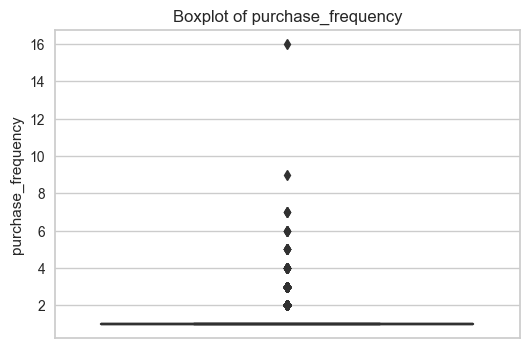

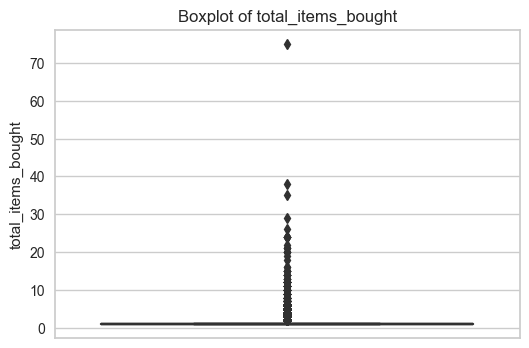

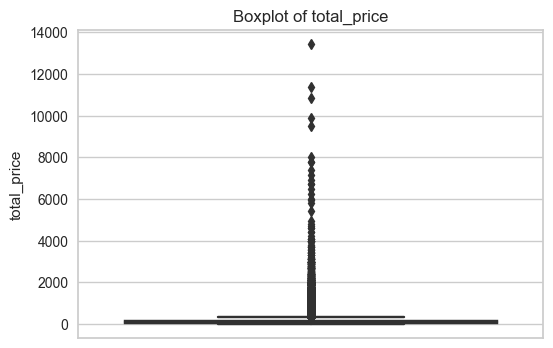

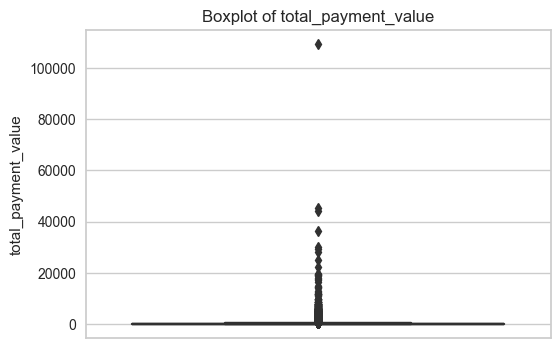

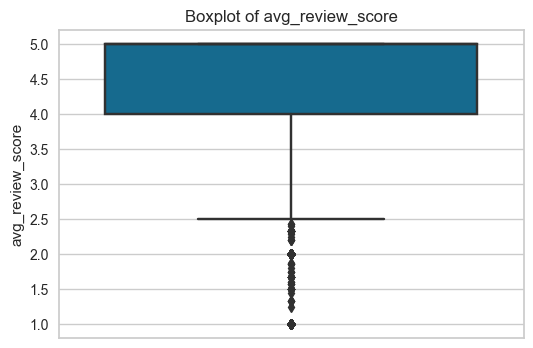

In [31]:
columns_to_plot = ['purchase_frequency', 'total_items_bought', 'total_price', 'total_payment_value', 'avg_review_score']

# Buat plot untuk setiap kolom
for column in columns_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=customer_behavior[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

## Clustering

### Preprocessing

In [32]:
data_cluster = customer_behavior.drop(columns='customer_unique_id')

In [33]:
# Standarisasi data untuk menangani outlier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cluster)

### Analisis

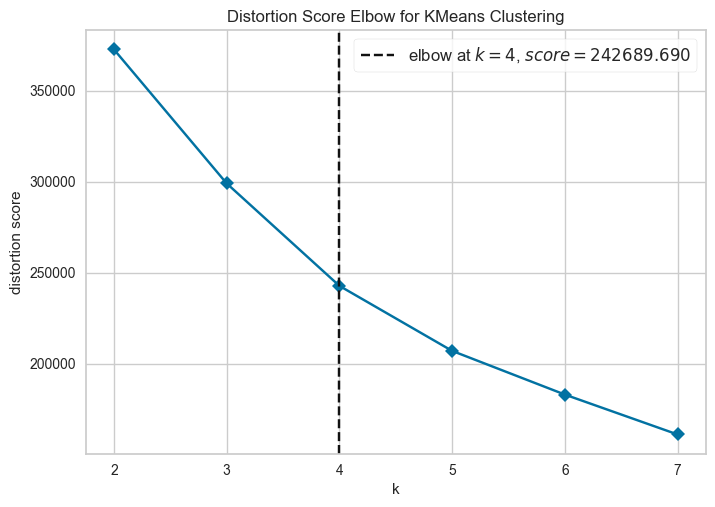

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
# Visualizer untuk menentukan jumlah cluster optimal
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2,8), timings=False)

# Fit data ke visualizer
visualizer.fit(data_scaled)  

# Menampilkan hasil visualisasi
visualizer.show()

In [35]:
from sklearn.metrics import silhouette_score
optimal_clusters = 4 
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data_cluster['cluster'] = kmeans.fit_predict(data_scaled)

silhouette_avg = silhouette_score(data_scaled, data_cluster['cluster'])
print('Nilai Silhouette: ', silhouette_avg)

Nilai Silhouette:  0.5734073045711178


Nilai Silhouette adalah metrik yang digunakan untuk mengukur seberapa baik objek dalam suatu klaster dikelompokkan. Nilai Silhouette berkisar antara -1 hingga 1:

* Nilai mendekati 1 menunjukkan bahwa objek sangat cocok dengan klaster mereka sendiri dan jauh dari klaster tetangga.
* Nilai mendekati 0 menunjukkan bahwa objek berada di perbatasan antara dua klaster, sehingga bisa termasuk dalam salah satu klaster.
* Nilai mendekati -1 menunjukkan bahwa objek mungkin lebih cocok di klaster yang berdekatan, daripada klaster mereka saat ini.

Dengan nilai Silhouette sebesar 0.573, ini menunjukkan bahwa segmentasi pelanggan yang cukup baik

In [36]:
# Analisis hasil clustering
data_cluster.groupby('cluster').mean()

,purchase_frequency,total_items_bought,total_price,total_payment_value,avg_review_score
cluster,,,,,
0,1.000000,1.242289,132.237721,196.545595,1.892593
1,1.000000,1.129269,122.531201,158.841809,4.741956
2,2.113942,2.800425,258.968507,388.587134,4.165455
3,1.043956,3.392372,1384.976639,2601.138571,3.839370


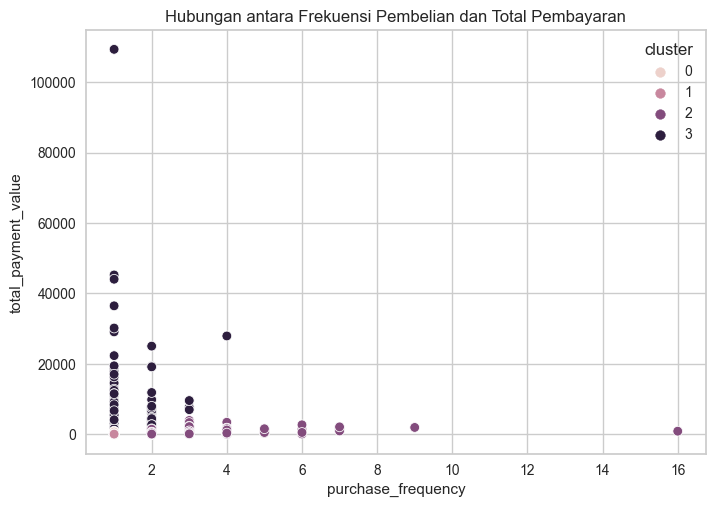

In [37]:
# Scatter plot untuk melihat hubungan antara frekuensi pembelian dan total nilai pembayaran
sns.scatterplot(x='purchase_frequency', y='total_payment_value', hue='cluster', data=data_cluster)
plt.title('Hubungan antara Frekuensi Pembelian dan Total Pembayaran')
plt.show()

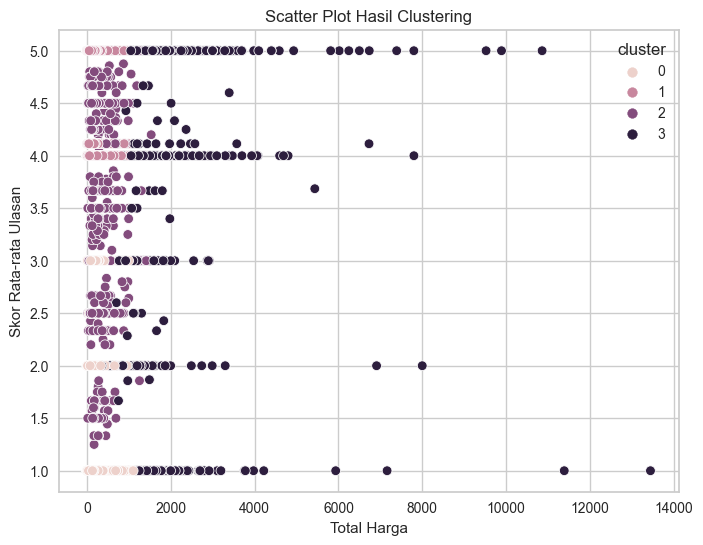

In [38]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_price', y='avg_review_score', data=data_cluster, hue='cluster')
plt.xlabel('Total Harga')
plt.ylabel('Skor Rata-rata Ulasan')
plt.title('Scatter Plot Hasil Clustering')
plt.show()

## Interpretasi Segmentasi Pelanggan

Berdasarkan hasil segmentasi pelanggan, terdapat empat klaster pelanggan yang diidentifikasi berdasarkan beberapa variabel: **purchase frequency** (frekuensi pembelian), **total items bought** (total barang yang dibeli), **total price** (total harga), **total payment value** (total nilai pembayaran), dan **avg review score** (rata-rata nilai ulasan). Berikut ini adalah interpretasi dan saran berdasarkan nilai-nilai dari masing-masing klaster:

## Klaster 0
- **Purchase Frequency:** 1.00
- **Total Items Bought:** 1.24
- **Total Price:** 132.24
- **Total Payment Value:** 196.55
- **Avg Review Score:** 1.89

**Interpretasi:**
- Pelanggan di klaster ini cenderung membeli dengan frekuensi yang rendah (sekali saja) dan hanya membeli sedikit barang. Nilai pembelian (total price) dan nilai pembayaran mereka relatif rendah. Rata-rata ulasan dari mereka sangat rendah, menunjukkan ketidakpuasan terhadap produk atau layanan.

**Saran:**
- Fokus pada peningkatan pengalaman pelanggan untuk klaster ini, misalnya dengan meningkatkan kualitas produk atau layanan dan memperhatikan masalah yang menyebabkan ketidakpuasan.
- Pertimbangkan program loyalitas atau diskon untuk mendorong mereka berbelanja lebih sering atau memberikan rekomendasi produk yang lebih baik.

## Klaster 1
- **Purchase Frequency:** 1.00
- **Total Items Bought:** 1.13
- **Total Price:** 122.53
- **Total Payment Value:** 158.84
- **Avg Review Score:** 4.74

**Interpretasi:**
- Klaster ini mirip dengan Klaster 0 dalam hal frekuensi pembelian dan jumlah barang yang dibeli, tetapi dengan rata-rata ulasan yang sangat baik. Pelanggan ini membeli sedikit, namun mereka sangat puas dengan produk atau layanan.

**Saran:**
- Pertahankan kualitas produk atau layanan yang telah diberikan kepada klaster ini.
- Karena mereka puas, mereka dapat menjadi pelanggan potensial untuk program referral atau promosi eksklusif.

## Klaster 2
- **Purchase Frequency:** 2.11
- **Total Items Bought:** 2.80
- **Total Price:** 258.97
- **Total Payment Value:** 388.59
- **Avg Review Score:** 4.17

**Interpretasi:**
- Pelanggan dalam klaster ini memiliki frekuensi pembelian yang lebih tinggi dan cenderung membeli lebih banyak barang dengan total nilai pembelian dan pembayaran yang lebih tinggi. Mereka juga memberikan ulasan yang cukup baik.

**Saran:**
- Pelanggan ini adalah pelanggan aktif yang cukup puas. Anda dapat menawarkan paket pembelian atau bundling untuk meningkatkan jumlah barang yang mereka beli.
- Program loyalitas yang memberikan poin untuk setiap pembelian atau review juga dapat meningkatkan frekuensi dan total pembelian mereka.

## Klaster 3
- **Purchase Frequency:** 1.04
- **Total Items Bought:** 3.39
- **Total Price:** 1384.98
- **Total Payment Value:** 2601.14
- **Avg Review Score:** 3.84

**Interpretasi:**
- Walaupun frekuensi pembeliannya hampir sama dengan klaster lain (sekali saja), pelanggan di klaster ini cenderung melakukan pembelian dalam jumlah yang besar dan dengan nilai total yang sangat tinggi. Ulasan mereka cukup positif, meskipun tidak setinggi klaster 1 dan 2.

**Saran:**
- Klaster ini berpotensi menjadi high-value customers. Pertimbangkan untuk memberikan layanan VIP atau penawaran eksklusif untuk menjaga loyalitas mereka.
- Mengidentifikasi faktor-faktor yang menyebabkan mereka hanya berbelanja sekali dan mencari cara untuk membuat mereka menjadi pelanggan berulang (repeat customers).

# Saran Umum untuk Perusahaan

- **Personalisasi Penawaran:** Gunakan hasil segmentasi ini untuk menawarkan produk, layanan, atau promosi yang sesuai dengan kebutuhan dan karakteristik setiap klaster.
- **Pengelolaan Loyalitas:** Pelanggan dengan frekuensi pembelian dan nilai transaksi yang tinggi harus diberikan perhatian khusus, seperti program loyalitas eksklusif, diskon khusus, atau layanan pelanggan prioritas.
- **Peningkatan Kualitas Layanan:** Untuk klaster yang memberikan review rendah, perlu dilakukan analisis lebih lanjut untuk mengidentifikasi masalah yang dihadapi dan memperbaiki kualitas layanan atau produk.
- **Program Pemasaran yang Ditargetkan:** Fokuskan kampanye pemasaran pada klaster yang memiliki potensi untuk ditingkatkan nilai pembeliannya.


In [39]:
customer_behavior['cluster']= data_cluster['cluster']
customer_behavior.to_csv('customer_behavior.csv')

## Klasifikasi Pelanggan

In [40]:
customer_behavior

,customer_unique_id,purchase_frequency,total_items_bought,total_price,total_payment_value,avg_review_score,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,129.90,141.90,5.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,27.19,4.0,1
2,0000f46a3911fa3c0805444483337064,1,1,69.00,86.22,3.0,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,25.99,43.62,4.0,1
4,0004aac84e0df4da2b147fca70cf8255,1,1,180.00,196.89,5.0,1
...,...,...,...,...,...,...,...
94977,fffcf5a5ff07b0908bd4e2dbc735a684,1,2,1570.00,4134.84,5.0,3
94978,fffea47cd6d3cc0a88bd621562a9d061,1,1,64.89,84.58,4.0,1
94979,ffff371b4d645b6ecea244b27531430a,1,1,89.90,112.46,5.0,1
94980,ffff5962728ec6157033ef9805bacc48,1,1,115.00,133.69,5.0,1


In [41]:
X = customer_behavior.drop(columns=['customer_unique_id', 'cluster'], axis=1)
y = customer_behavior['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Ukuran data latih:", X_train.shape, y_train.shape)
print("Ukuran data uji:", X_test.shape, y_test.shape)

Ukuran data latih: (75985, 5) (75985,)
Ukuran data uji: (18997, 5) (18997,)


In [42]:
y_train.value_counts()

1    56657
0    15877
2     2224
3     1227
Name: cluster, dtype: int64

In [43]:
#  RandomUnderSampler untuk kelas 1 dan 0 sebesar 50%
rus = RandomUnderSampler(sampling_strategy={0: int(y_train.value_counts()[0] * 0.5), 1: int(y_train.value_counts()[1] * 0.5)}, random_state=42)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print("Jumlah sampel setiap kelas setelah undersampling:")
print(y_train_resampled.value_counts())

Jumlah sampel setiap kelas setelah undersampling:
1    28328
0     7938
2     2224
3     1227
Name: cluster, dtype: int64


In [44]:
# Inisialisasi model
logreg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)

logreg.fit(X_train_resampled, y_train_resampled)
rf.fit(X_train_resampled, y_train_resampled)
svm.fit(X_train_resampled, y_train_resampled)

y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_svm = svm.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("Akurasi Regresi Logistik:", accuracy_logreg)
print("Akurasi Random Forest:", accuracy_rf)
print("Akurasi SVM:", accuracy_svm)

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Akurasi Regresi Logistik: 0.9021950834342265
Akurasi Random Forest: 0.9992630415328736
Akurasi SVM: 0.7563825867242197


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3996
           1       1.00      1.00      1.00     14079
           2       1.00      1.00      1.00       602
           3       0.97      0.99      0.98       320

    accuracy                           1.00     18997
   macro avg       0.99      1.00      0.99     18997
weighted avg       1.00      1.00      1.00     18997



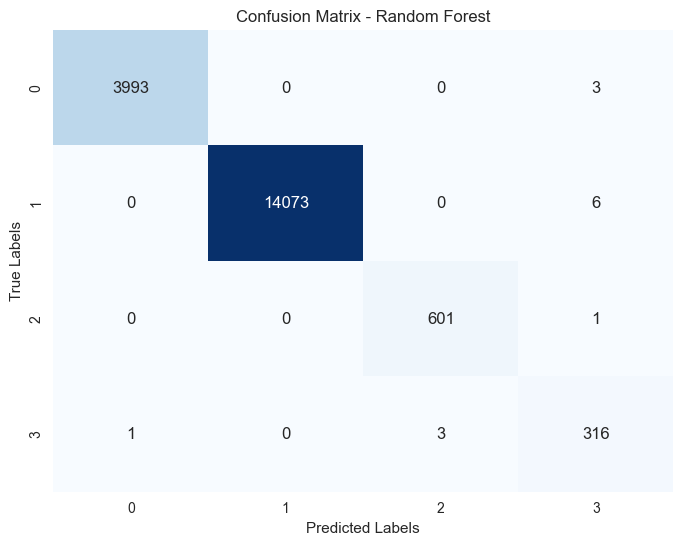

In [45]:
print(classification_report(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

## Kesimpulan Klasifikasi

* Klasifikasi dibentuk untuk memprediksi klaster mana seorang pelanggan baru atau yang belum diklasterkan akan tergolong berdasarkan karakteristik klaster 
* Data dilatih dengan 3 metode klasifikasi (Random Forest, Regresi Logistik dan Support Vector Machine)
* Performa model dalam memprediksi data latih mendapatkan 99% akurasi yang berarti model sangat baik dalam memprediksi klaster pelanggan